# Univariate Gaussianization

In [1]:
#@title Install Packages
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here", "setup.py"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", False)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# get data
n_samples = 1_000
n_features = 1
data = get_classic(n_samples)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

<AxesSubplot:ylabel='Density'>

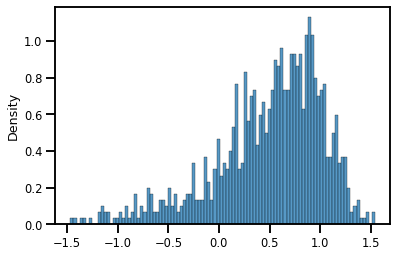

In [4]:
X = np.array(data[:, 1], dtype=np.float32).reshape(-1, 1)

sns.histplot(X.ravel(), bins=100, stat="density")

## Histogram Uniformization

In [8]:
from rbig_jax.transforms.histogram import InitUniHistTransform
from rbig_jax.transforms.kde import InitUniKDETransform, estimate_bw

# Histogram transform
support_extension = 20
alpha = 1e-5
precision = 1_000
nbins = int(np.sqrt(X.shape[0]))

# initialize histogram transformation
init_hist_f = InitUniHistTransform(
    n_samples=X.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)


#### Initialize + Forward Transform

In [9]:
# initialize bijector
X_u, hist_bijector = init_hist_f.init_bijector(X)
# X_u, hist_bijector = jax.jit(init_hist_f.init_bijector)(X)

# initialize parameters
X_u_, hist_bijector = init_hist_f.init_params(X)
# X_u_, hist_bijector = jax.jit(init_hist_f.init_params)(X)
chex.assert_tree_all_close(X_u, X_u_)

# init and transform
X_u_ = init_hist_f.init_transform(X)
# X_u_ = jax.jit(init_hist_f.init_transform)(X)
chex.assert_tree_all_close(X_u, X_u_)

In [10]:
# initialize bijector
X_u, hist_bijector = init_hist_f.init_bijector(X)

# forward transformation
X_l1 = hist_bijector.forward(X)

# inverse transformation
X_approx = hist_bijector.inverse(X_l1)

# gradient transformation
X_l1_ldj = hist_bijector.forward_log_det_jacobian(X_l1)

#### Plot

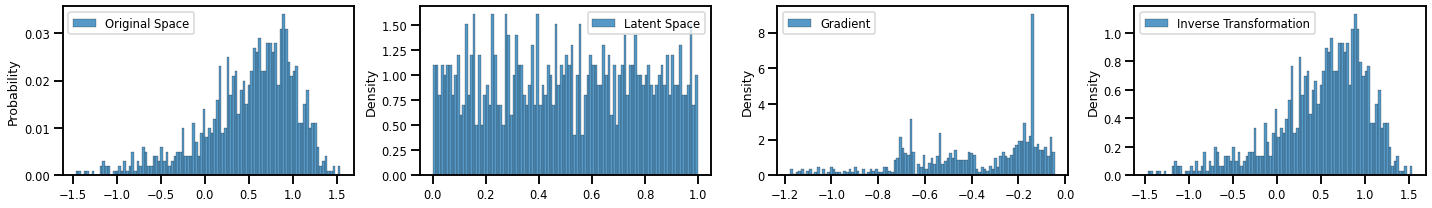

In [11]:
# plot
fig, ax = plt.subplots(ncols=4, figsize=(20, 3))
# Original Space
sns.histplot(X.ravel(), bins=100, stat="probability", label="Original Space", ax=ax[0])
ax[0].legend()
# Latent Space
sns.histplot(X_l1.ravel(), bins=100, label="Latent Space", stat="density", ax=ax[1])
ax[1].legend()

# Gradient Transform
sns.histplot(X_l1_ldj.ravel(), bins=100, label="Gradient", stat="density", ax=ax[2])
ax[2].legend()
# Inverse Transform
sns.histplot(X_approx.ravel(), bins=100, label="Inverse Transformation", stat="density", ax=ax[3])
ax[3].legend()

plt.legend()
plt.tight_layout()
plt.show()

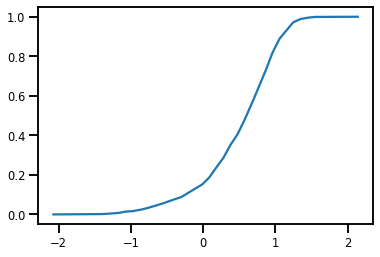

In [12]:
plt.plot(hist_bijector.support.ravel(), hist_bijector.quantiles.ravel())

## Inverse CDF Estimation

#### Logit

In [13]:
# Logit transform
from rbig_jax.transforms.logit import InitLogitTransform

init_logit_f = InitLogitTransform()

#### Init + Transform

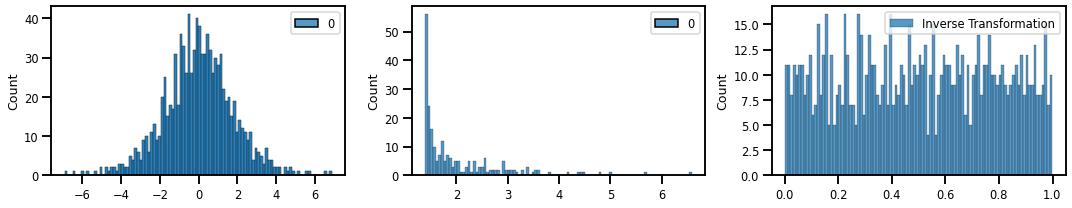

In [14]:
X_g, logit_bijector = init_logit_f.init_bijector(X_u)
X_g_ = logit_bijector.forward(X_u)
X_u_approx = logit_bijector.inverse(X_g)
X_g_ldj = logit_bijector.forward_log_det_jacobian(X_g)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_g, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_g_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_g_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_u_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

### Inverse Gaussian CDF

In [42]:
from rbig_jax.transforms.inversecdf import InitInverseGaussCDFTransform

# univariate normalization Gaussianization parameters
eps = 1e-5

# initialize histogram transformation
init_icdf_f = InitInverseGaussCDFTransform(eps=eps)

### Transformations

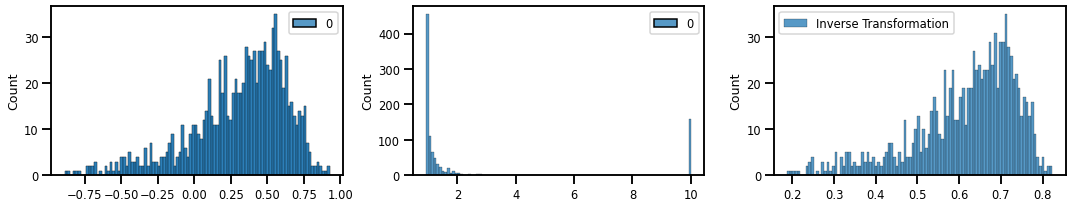

In [43]:
X_g, icdf_bijector = init_icdf_f.init_bijector(X_u)
X_g_ = icdf_bijector.forward(X_u)
X_u_approx = icdf_bijector.inverse(X_g)
X_g_ldj = icdf_bijector.forward_log_det_jacobian(X_g)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_g, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_g_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_g_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_u_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

### Stacking Transformations Together

#### Example I - Histogram + Logit

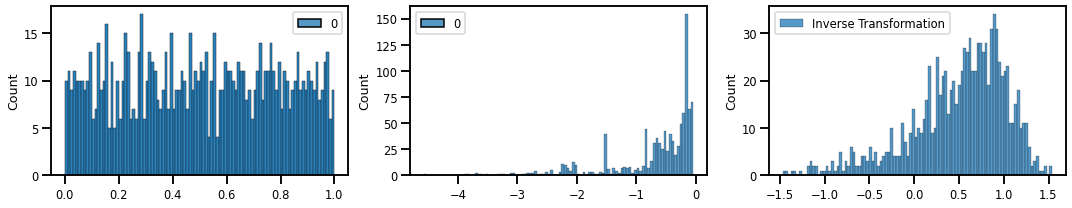

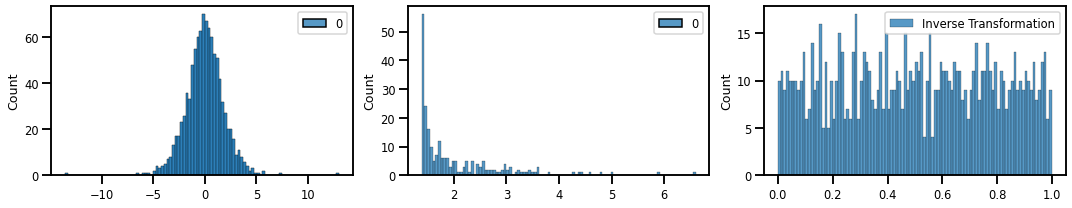

In [44]:
X_u, hist_bijector = init_hist_f.init_bijector(X)
X_u_ = hist_bijector.forward(X)
X_approx = hist_bijector.inverse(X_u)
X_u_ldj = hist_bijector.forward_log_det_jacobian(X)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_u, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_u_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_u_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

X_g, logit_bijector = init_logit_f.init_bijector(X_u)
X_g_ = logit_bijector.forward(X_u)
X_u_approx = logit_bijector.inverse(X_g)
X_g_ldj = logit_bijector.forward_log_det_jacobian(X_g)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_g, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_g_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_g_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_u_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

#### Example II - Inverse Gauss CDF

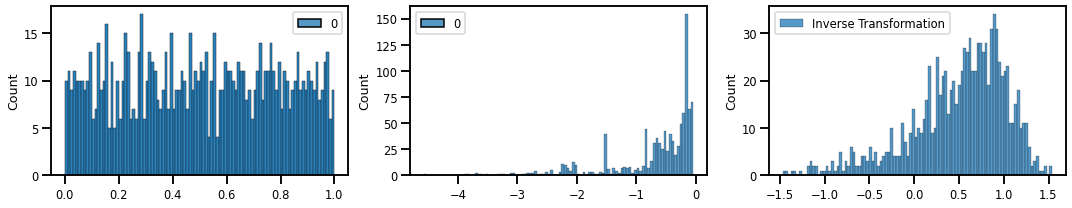

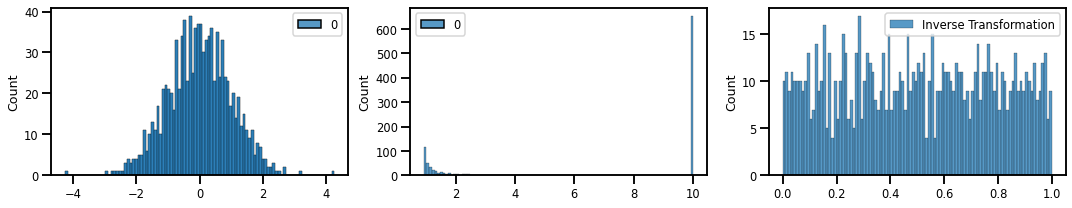

In [45]:
X_u, hist_bijector = init_hist_f.init_bijector(X)
X_u_ = hist_bijector.forward(X)
X_approx = hist_bijector.inverse(X_u)
X_u_ldj = hist_bijector.forward_log_det_jacobian(X)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_u, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_u_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_u_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()


X_g, icdf_bijector = init_icdf_f.init_bijector(X_u)
X_g_ = icdf_bijector.forward(X_u)
X_u_approx = icdf_bijector.inverse(X_g)
X_g_ldj = icdf_bijector.forward_log_det_jacobian(X_g)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_g, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_g_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_g_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_u_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

#### Example III - Sigmoid + Histogram + Logit

In [46]:
from distrax._src.bijectors.sigmoid import Sigmoid

In [47]:
sigmoid_bijector = Sigmoid()

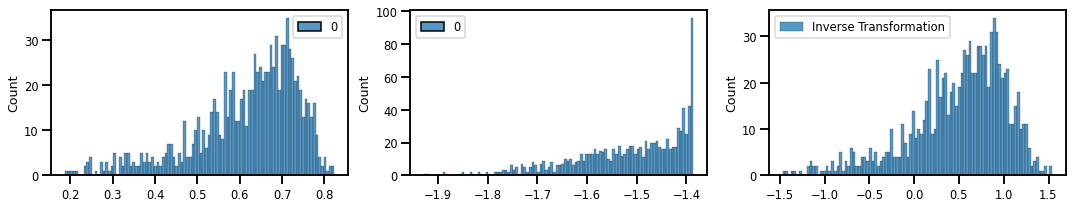

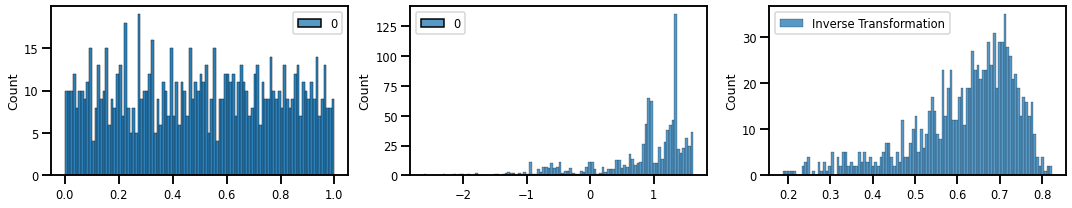

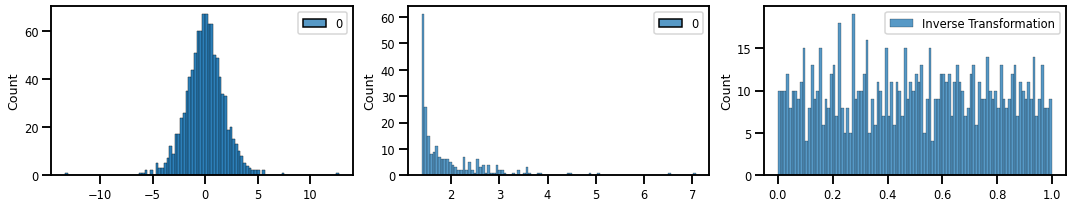

In [48]:
# ==========================
# SIGMOID Function
# ==========================

X_u = sigmoid_bijector.forward(X)
X_approx = sigmoid_bijector.inverse(X_u)
X_u_ldj = sigmoid_bijector.forward_log_det_jacobian(X)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_u, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_u_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

# ==========================
# HISTOGRAM
# ==========================
support_extension = 1e-5
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(X.shape[0]))

# initialize histogram transformation
init_hist_f = InitUniHistTransform(
    n_samples=X.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

X_u_l2, hist_bijector = init_hist_f.init_bijector(X_u)
X_u_l2_ = hist_bijector.forward(X_u)
X_u_approx = hist_bijector.inverse(X_u_l2)
X_u_ldj = hist_bijector.forward_log_det_jacobian(X_u)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_u_l2, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_u_l2_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_u_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_u_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

# ==========================
# INVERSE Function
# ==========================

X_g, logit_bijector = init_logit_f.init_bijector(X_u_l2)
X_g_ = logit_bijector.forward(X_u_l2)
X_u_approx = logit_bijector.inverse(X_g)
X_g_ldj = logit_bijector.forward_log_det_jacobian(X_g)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_g, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_g_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_g_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_u_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

#### 

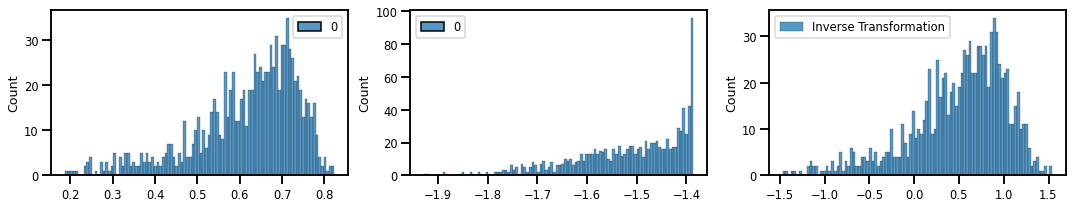

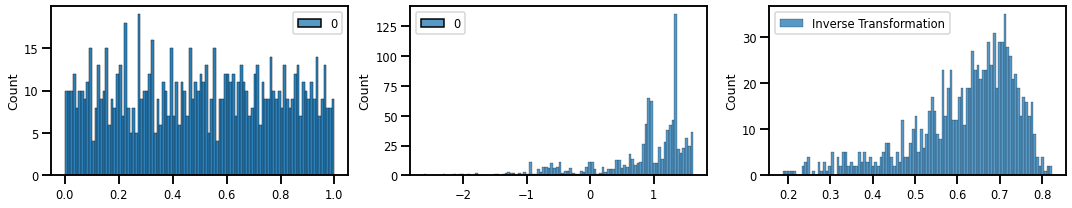

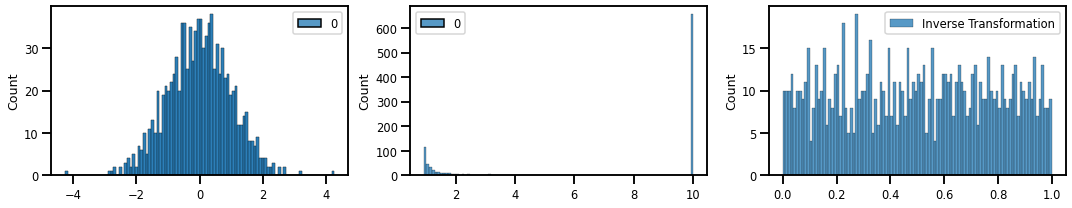

In [49]:
# ==========================
# SIGMOID Function
# ==========================

X_u = sigmoid_bijector.forward(X)
X_approx = sigmoid_bijector.inverse(X_u)
X_u_ldj = sigmoid_bijector.forward_log_det_jacobian(X)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_u, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_u_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

# ==========================
# HISTOGRAM
# ==========================
support_extension = 1e-5
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(X.shape[0]))

# initialize histogram transformation
init_hist_f = InitUniHistTransform(
    n_samples=X.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

X_u_l2, hist_bijector = init_hist_f.init_bijector(X_u)
X_u_l2_ = hist_bijector.forward(X_u)
X_u_approx = hist_bijector.inverse(X_u_l2)
X_u_ldj = hist_bijector.forward_log_det_jacobian(X_u)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_u_l2, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_u_l2_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_u_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_u_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

# ==========================
# INVERSE Function
# ==========================

X_g, icdf_bijector = init_icdf_f.init_bijector(X_u_l2)
X_g_ = icdf_bijector.forward(X_u_l2)
X_u_approx = icdf_bijector.inverse(X_g)
X_g_ldj = icdf_bijector.forward_log_det_jacobian(X_g)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_g, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_g_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_g_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_u_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

## Convenience Function

In [51]:
from rbig_jax.transforms.block import RBIGBlock

In [52]:
init_functions = [
    init_hist_f,
    init_icdf_f
]

rbig_block = RBIGBlock(init_functions=init_functions)

<AxesSubplot:ylabel='Count'>

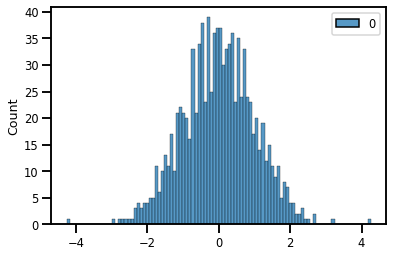

In [56]:
X_g, bijectors = rbig_block.forward_and_params(X)


# plot
sns.histplot(X_g, bins=100, label="Gaussianized")


In [58]:
X_g, bijectors = jax.jit(rbig_block.forward_and_params)(X)